# EDA on DATASET
### Notebook guide:
***This notebook has the following parts***
1. **Loading the data set** :  Load the hotel review dataset
2. **Clean the dataset** : using mostly textacy library make lowercase,remove whitespace,replace hashtaggs,phone_numers,urls,emails,remove html_tags punctuation,replace emoji by meaning
3. **check the clean data** : dropping outliers i.e very long text reviews
4. **observations on the eda** 

## 1. Load and Check data

In [1]:
import pandas as pd

review_org_data = pd.read_csv('./data/tripadvisor_hotel_reviews.csv')

In [2]:
review_org_data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [3]:
review_org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [4]:
review_org_dat = review_org_data.dropna().drop_duplicates()

In [5]:
review_org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [6]:
review_org_data.describe(include='all')

,Review,Rating
count,20491,20491.000000
unique,20491,NaN
top,nice hotel expensive parking got good deal sta...,NaN
freq,1,NaN
mean,NaN,3.952223
std,NaN,1.233030
min,NaN,1.000000
25%,NaN,3.000000
50%,NaN,4.000000
75%,NaN,5.000000


<AxesSubplot:>

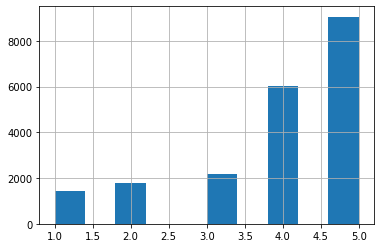

In [7]:
review_org_data['Rating'].hist()

In [ ]:
## Looks like the data is skewed, as negative ratings has less number of samples than positive ratings

## 2. Clean the dataset

In [8]:
# lets apply some standard preporcessing for the data 
# lowercase
# remove whitespace,replace hashtaggs,phone_numers,urls,emails
# remove html_tags punctuation
# replace emoji by meaning

In [12]:
import re
import textacy
from textacy import preprocessing
from emoji_translate.emoji_translate import Translator
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

emo = Translator(exact_match_only=False, randomize=True)


def remove_stopword(x):
    return [y for y in x.split(' ') if y not in stopwords.words('english')]
    # return (' ').join([y for y in x.split(' ') if y not in stopwords.words('english')])


def text_preprocessing(text):
    '''
     lowercase,remove whitespace,replace hashtaggs,phone_numers,urls,emails
     remove html_tags punctuation
     replace emoji by meaning
    '''
    text_new = text.lower()
    text_new = re.sub(' +', ' ', text_new)
    text_new = textacy.preprocessing.replace.hashtags(text_new, repl='_HASH_')
    text_new = textacy.preprocessing.replace.phone_numbers(text_new,
                                                           repl='_PHONENUM_')
    text_new = textacy.preprocessing.remove.html_tags(text_new)
    text_new = textacy.preprocessing.replace.urls(text_new, repl='_URL_')
    text_new = textacy.preprocessing.replace.emails(text_new, repl='_EMAIL_')
    text_new = textacy.preprocessing.remove.punctuation(text_new,
                                                        only=[",", ";", ":"])
    text_new = emo.demojify(text_new)
    return text_new

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# TODO: using parallel processing here to make it faster
review_org_data['clean_text'] = review_org_data['Review'].apply(
    lambda x: text_preprocessing(x))

In [13]:
# TODO: using parallel processing here
review_org_data['word_list'] = review_org_data['clean_text'].apply(lambda x : remove_stopword(x))

In [17]:
review_org_data['text_length'] = review_org_data["word_list"].apply(lambda x : len(x))

In [18]:
review_org_data.head()

,Review,Rating,clean_text,word_list,text_length
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,"[nice, hotel, expensive, parking, got, good, d...",92
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,"[ok, nothing, special, charge, diamond, member...",257
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...,"[nice, rooms, 4*, experience, hotel, monaco, s...",227
3,"unique, great stay, wonderful time hotel monac...",5,unique great stay wonderful time hotel monac...,"[unique, , great, stay, , wonderful, time, hot...",99
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game aweso...,"[great, stay, great, stay, , went, seahawk, ga...",213


# 3. Check the clean data

<AxesSubplot:ylabel='Count'>

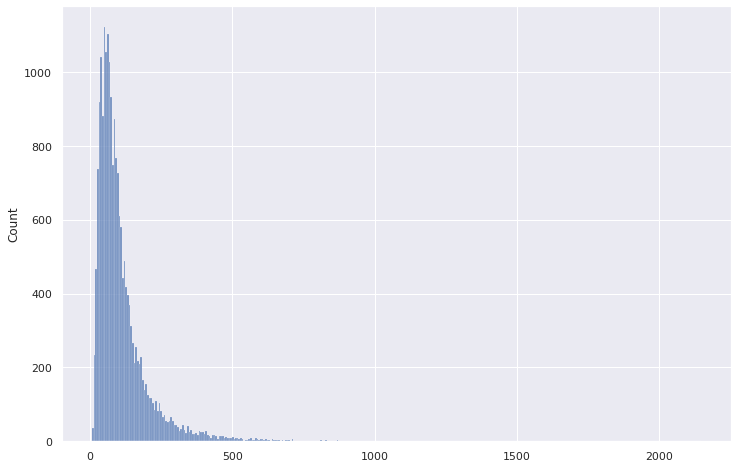

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)
plt.figure(figsize=(12,8))
sns.histplot(list(review_org_data['text_length'].values))

In [21]:
# let's check common words on the entire corpus
from collections import Counter
top = Counter([item for sublist in review_org_data['word_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,hotel,48765
2,room,34240
3,great,21057
4,n't,18984
5,good,16944
6,staff,16181
7,stay,15138
8,nice,12385
9,rooms,11994


In [23]:
# let's check common words on negative reviews

x = review_org_data[review_org_data['Rating'].isin([1,2])]
top = Counter([item for sublist in x['word_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,hotel,7756
2,room,7517
3,n't,4032
4,stay,2575
5,rooms,2247
6,staff,2241
7,good,2090
8,service,2027
9,night,2014


In [24]:
# let's check common words on positive reviews

x = review_org_data[review_org_data['Rating'].isin([4,5])]
top = Counter([item for sublist in x['word_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,hotel,35949
2,room,22299
3,great,18079
4,staff,12472
5,good,12402
6,n't,12364
7,stay,11154
8,nice,9233
9,location,8671


## 4. Observations of EDA
**1. Dataset is skewed, postive ratings are more than negative ratings**

**2. Most of the text length is below 500, we can use this info for bert model**

**3. Tried checking the most common words for different corpus, didn't find much insights**